In [1]:
#THIS FILE MAY ONLY BE RUN *ONCE* WHEN THE PATH "/data/all_images" EXISTS
'''
----------14 January 2024 | Aarya Bhave | Commited to Skin_Cancer_Diagnosis----------
Before running this file locally, you must have all 10,015 HAM10000 images in a directory with path '/data/all_images/.
This code carries out the sorting and reorganizing of all the image data in '/data/all_images/' folder.
This code WILL DELETE '/data/all_images/' after creating the '/data/reorganized/' folder to save space.
The '/data/reorganized/' folder will contain a proper sorted deep-copy of all the images from the original data pool.
This file must be run with '/Model_Construction/' as current working directory.
This file fixes the dataset skew and increases image count to ~42000 images.
'''

#IMPORT LIBRARIES :
import pandas as pd 
import os
import shutil
import random
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img

2024-01-17 13:32:18.553084: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-17 13:32:18.579953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 13:32:18.579989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 13:32:18.580649: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 13:32:18.585389: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#Sort the images into a flow_from_dir capable folder structure
#Create destination directory
os.mkdir('data/reorganized_train')
os.mkdir('data/reorganized_validation')
os.mkdir('data/reorganized_test')

#Data pool
data_dir = os.getcwd() + "/data/all_images/"

#Path to destination directories
train_dir = os.getcwd() + "/data/reorganized_train/"
test_dir = os.getcwd() + "/data/reorganized_test/"
validation_dir = os.getcwd() + "/data/reorganized_validation/"

In [3]:
#Set up the image augmenter
datagen = K.preprocessing.image.ImageDataGenerator(
    rotation_range = 2,
    shear_range = 0.01,
    zoom_range = 0.01,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

In [5]:
#Load metadata
metadata_frame = pd.read_csv('data/HAM10000_metadata.csv')

#The dataset is skewed as follows:
print(metadata_frame['dx'].value_counts())

#Extract labels into a list
label = metadata_frame['dx'].unique().tolist()
label_images = []

#Keep counts
test_examples = train_examples = validation_examples = 0

#Create dictionary to balance weights
balance_dict = {
    'nv' : 0,
    'mel' : 5,
    'bkl' : 5,
    'bcc' : 13,
    'akiec' : 20,
    'vasc' :  45,
    'df' : 58
}

#Graphing help
count_dict = {
    'nv' : 0,
    'mel' : 0,
    'bkl' : 0,
    'bcc' : 0,
    'akiec' : 0,
    'vasc' :  0,
    'df' : 0
}

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [6]:
#Copy all the images to subfolders
for i in label:
    os.mkdir(train_dir + str(i) + "/")
    os.mkdir(test_dir + str(i) + "/")
    os.mkdir(validation_dir + str(i) + "/")
    sample = metadata_frame[metadata_frame['dx'] == i]['image_id']
    label_images.extend(sample)
    for id in label_images:
        random_num = random.uniform(0, 1)
        if(random_num<0.8):
            #Add to training set.
            shutil.copyfile((data_dir+"/"+id+".jpg"), (train_dir+i+"/"+id+".jpg"))
            train_examples+=1
            count_dict[i]+=1
            if(balance_dict[i]>0):
                img = load_img(data_dir+"/"+id+".jpg")
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                count = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=(train_dir+i), save_prefix='augmented', save_format='jpg'):
                    count+=1
                    train_examples+=1
                    count_dict[i]+=1
                    if(count>balance_dict[i]):
                        break
        elif(random_num<0.9):
            #Add to crossvalidation set.
            shutil.copyfile((data_dir+"/"+id+".jpg"), (validation_dir+i+"/"+id+".jpg"))
            validation_examples+=1
            count_dict[i]+=1
            if(balance_dict[i]>0):
                img = load_img(data_dir+"/"+id+".jpg")
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                count = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=(validation_dir+i), save_prefix='augmented', save_format='jpg'):
                    count+=1
                    validation_examples+=1
                    count_dict[i]+=1
                    if(count>balance_dict[i]):
                        break
        else:
            #Add to testing set.
            shutil.copyfile((data_dir+"/"+id+".jpg"), (test_dir+i+"/"+id+".jpg"))
            test_examples+=1
            count_dict[i]+=1
            if(balance_dict[i]>0):
                img = load_img(data_dir+"/"+id+".jpg")
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                count = 0
                for batch in datagen.flow(x, batch_size=1, save_to_dir=(test_dir+i), save_prefix='augmented', save_format='jpg'):
                    count+=1
                    test_examples+=1
                    count_dict[i]+=1
                    if(count>balance_dict[i]):
                        break
    label_images = []

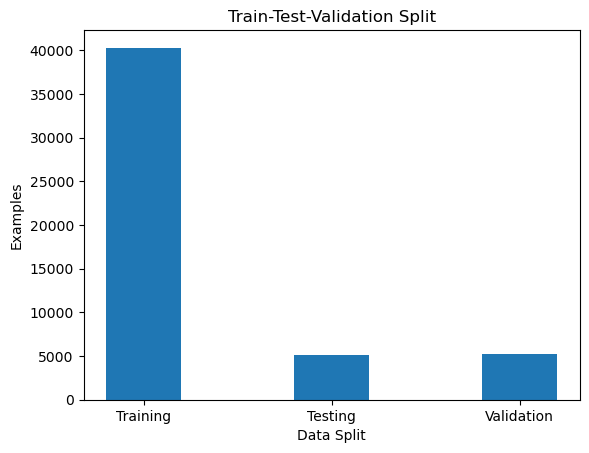

In [7]:
#Data visualization
graph_data = {'Training' : train_examples, 'Testing' : test_examples, 'Validation' : validation_examples}
plt.bar(list(graph_data.keys()), list(graph_data.values()), width=0.4)
plt.xlabel("Data Split")
plt.ylabel("Examples")
plt.title("Train-Test-Validation Split")
plt.show()

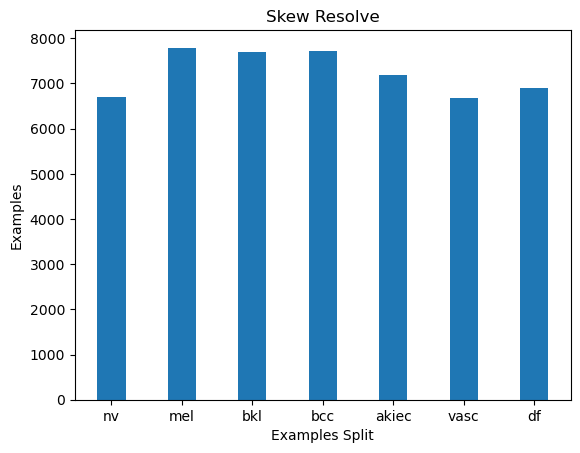

In [14]:
#Graphing
label_names = list(count_dict.keys())
label_values = list(count_dict.values())
plt.bar(label_names, label_values, width=0.4)
plt.xlabel("Examples Split")
plt.ylabel("Examples")
plt.title("Skew Resolve")
plt.show()

In [ ]:
#Get rid of the original data pool to save space
shutil.rmtree('data/all_images')